In [454]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.impute import SimpleImputer

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import scorecardpy as sc

import warnings
warnings.filterwarnings('ignore')

In [455]:
train = pd.read_csv('C:\\Users\\Овчинниковы\\Desktop\\Полезная всячина\\DataSets\\give-me-some-credit-20210326\\train.csv')
test = pd.read_csv('C:\\Users\\Овчинниковы\\Desktop\\Полезная всячина\\DataSets\\give-me-some-credit-20210326\\test.csv')
description = pd.read_excel('C:\\Users\\Овчинниковы\\Desktop\\Полезная всячина\\DataSets\\give-me-some-credit-20210326\\Data Dictionary.xls')
sample_sub = pd.read_csv('C:\\Users\\Овчинниковы\\Desktop\\Полезная всячина\\DataSets\\give-me-some-credit-20210326\\sample_submission.csv')

In [456]:
# Дропаем id
train.drop('Id', axis=1, inplace=True)

In [457]:
# Проверяем на дубликаты
train.duplicated().sum()

353

In [458]:
# Дропаем дубликаты
train.drop_duplicates(inplace=True, ignore_index=True)

In [459]:
# Предикторы и зависимые переменные
target = train.SeriousDlqin2yrs
features = train.iloc[:, 1:]

In [460]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104452 entries, 0 to 104451
Data columns (total 10 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   RevolvingUtilizationOfUnsecuredLines  104452 non-null  float64
 1   age                                   104452 non-null  int64  
 2   NumberOfTime30-59DaysPastDueNotWorse  104452 non-null  int64  
 3   DebtRatio                             104452 non-null  float64
 4   MonthlyIncome                         83959 non-null   float64
 5   NumberOfOpenCreditLinesAndLoans       104452 non-null  int64  
 6   NumberOfTimes90DaysLate               104452 non-null  int64  
 7   NumberRealEstateLoansOrLines          104452 non-null  int64  
 8   NumberOfTime60-89DaysPastDueNotWorse  104452 non-null  int64  
 9   NumberOfDependents                    101757 non-null  float64
dtypes: float64(4), int64(6)
memory usage: 8.0 MB


In [461]:
features.head()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
1,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
2,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
3,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
4,0.213179,74,0,0.375607,3500.0,3,0,1,0,1.0


In [462]:
description.iloc[2, 1]

'Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits'

In [463]:
# Нулевой возраст(невозможно), нулевой ежемесячный доход(возможно, но важно),
features.describe()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,104452.000000,104452.000000,104452.000000,104452.000000,8.395900e+04,104452.000000,104452.000000,104452.000000,104452.000000,101757.000000
mean,5.619242,52.364837,0.390275,356.053455,6.689040e+03,8.478210,0.233619,1.022996,0.209158,0.758267
std,217.756704,14.725083,3.813994,2172.747226,1.565831e+04,5.120052,3.787095,1.137218,3.771295,1.113034
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.029997,41.000000,0.000000,0.176965,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.153982,52.000000,0.000000,0.368022,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.557240,63.000000,0.000000,0.873129,8.250000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,29110.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,13.000000


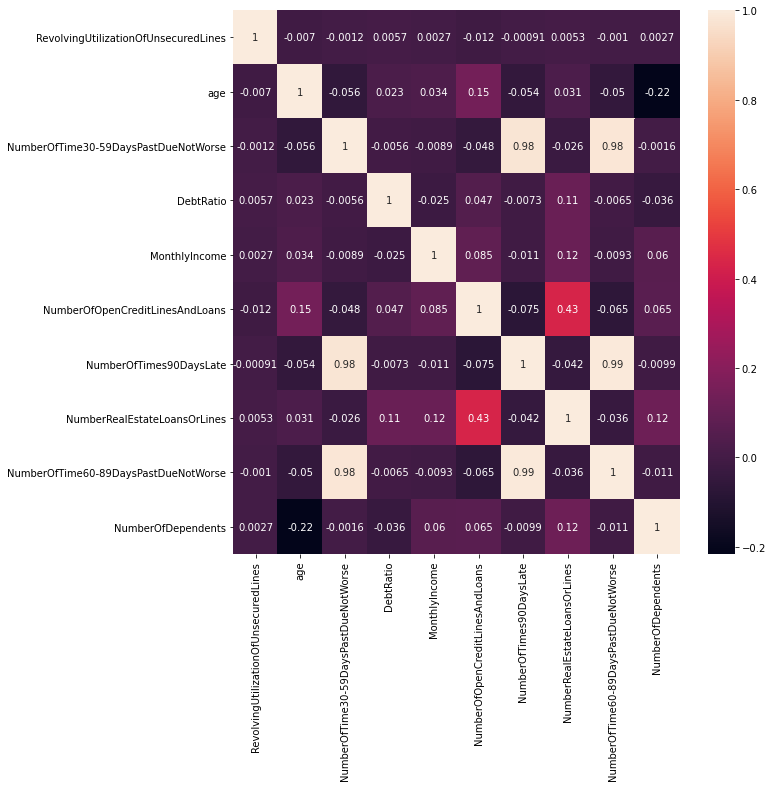

In [464]:
# Одна из предпосылок логистической регрессии - отсутствие мультиколлинеарности между предикторами
plt.figure(figsize=(10, 10))
sns.heatmap(features.corr(), annot=True)

In [465]:
# Корреляция близкая к 1 у признаков - 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTimes90DaysLate'
# Так же у них присутствуют два невозможных значения - 98 и 96. Скорее всего эти значения не обозначают количество
features['NumberOfTimes90DaysLate'].value_counts()

0     98769
1      3601
2      1043
3       466
4       202
98      152
5        89
6        56
7        27
9        14
8        12
10        6
11        4
12        2
96        2
13        2
14        2
15        2
17        1
Name: NumberOfTimes90DaysLate, dtype: int64

Название признака - RevolvingUtilizationOfUnsecuredLines


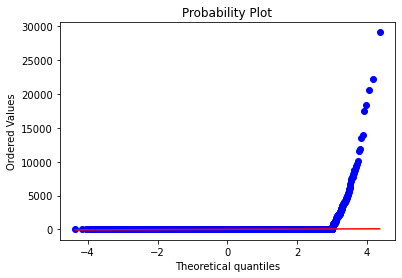

Название признака - age


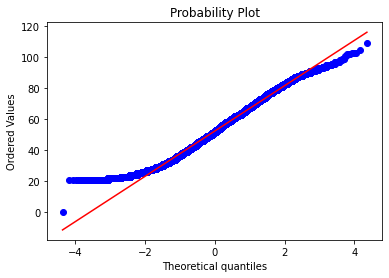

Название признака - NumberOfTime30-59DaysPastDueNotWorse


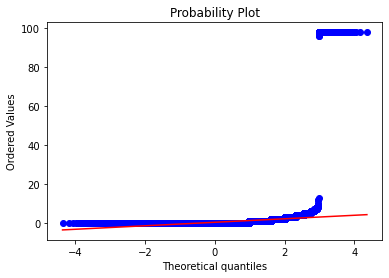

Название признака - DebtRatio


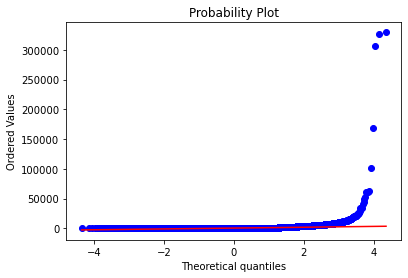

Название признака - MonthlyIncome


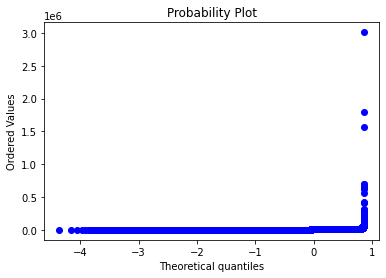

Название признака - NumberOfOpenCreditLinesAndLoans


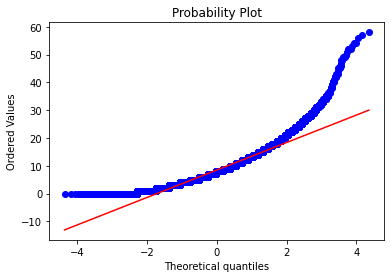

Название признака - NumberOfTimes90DaysLate


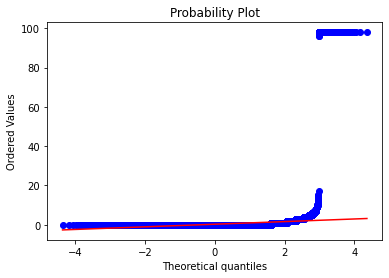

Название признака - NumberRealEstateLoansOrLines


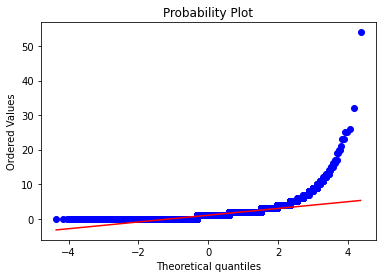

Название признака - NumberOfTime60-89DaysPastDueNotWorse


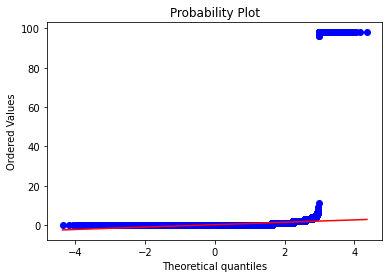

Название признака - NumberOfDependents


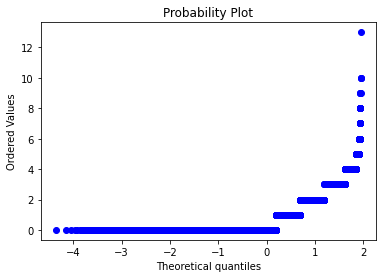

In [466]:
# Эти значения являются выбросами в том формате, в котором они находятся сейчас
for i in features.columns:
    print('Название признака -',i)
    plt.figure()
    stats.probplot(features[i], plot=plt)
    plt.show()

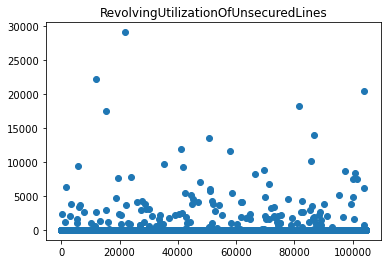

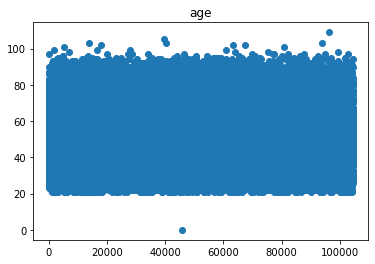

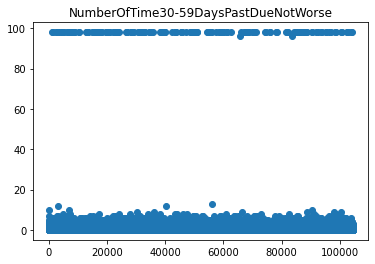

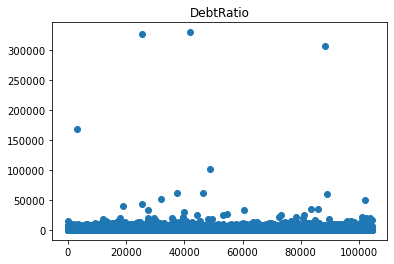

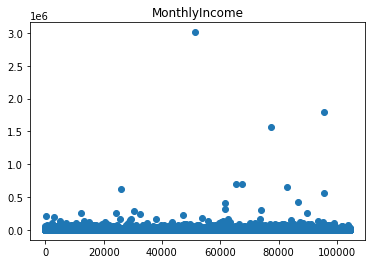

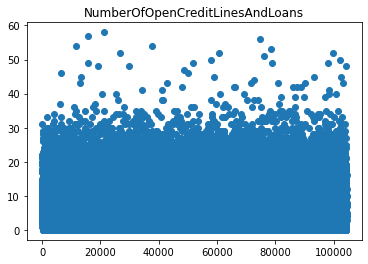

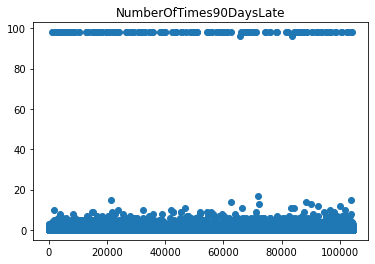

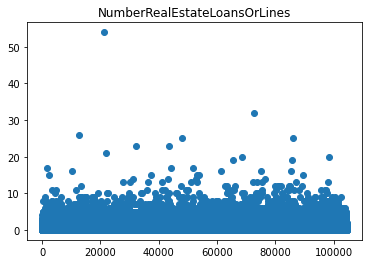

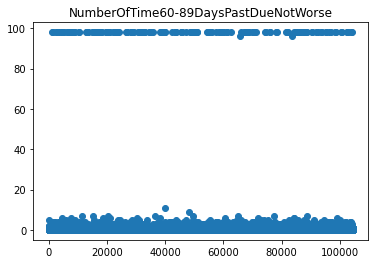

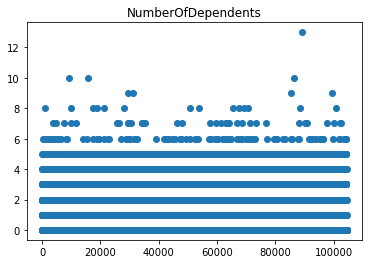

In [467]:
for i in features.columns:
    plt.figure()
    plt.title(i)
    plt.scatter(features.index, features[i])

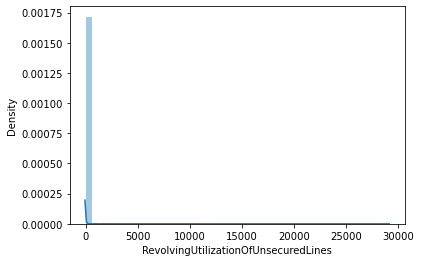

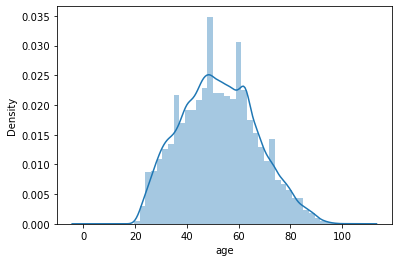

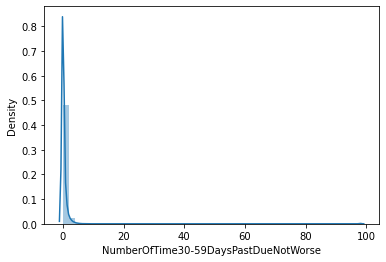

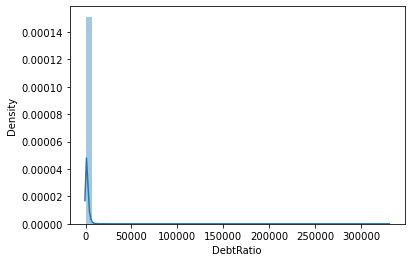

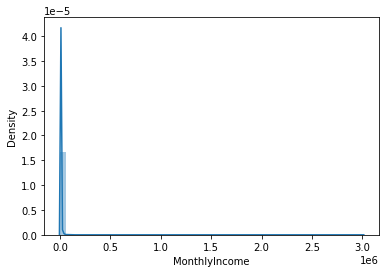

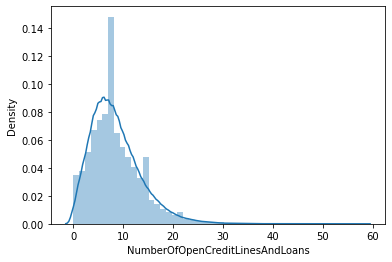

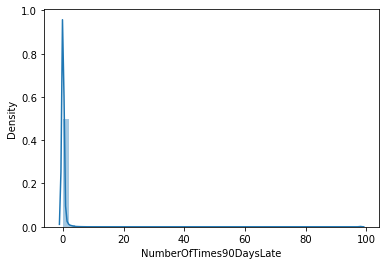

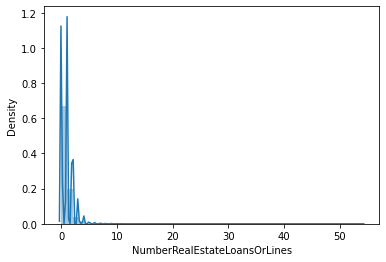

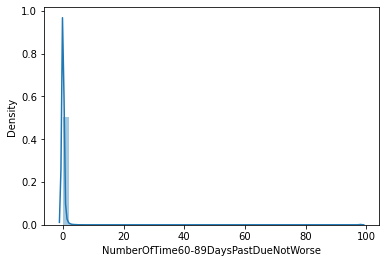

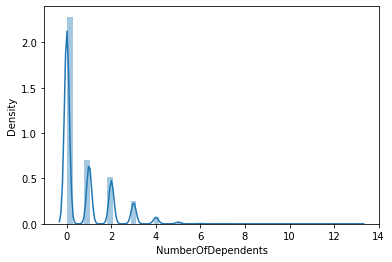

In [468]:
for i in features.columns:
    plt.figure()
    sns.distplot(features[i])

### Выбросы

In [469]:
# Так как мы собираемся проводить биннинг, то заменим "странные" значения на пропуски. 
# Пропущенные значения уйдут в отдельные категории. В других переменных пропущенные значения импутируем

In [470]:
features.isna().sum()

RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           20493
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       2695
dtype: int64

In [471]:
nan_feat = ['NumberOfTimes90DaysLate', 'NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse']

features[nan_feat] = np.where(features[nan_feat] > 20, np.nan, features[nan_feat])

In [472]:
nan_feat = ['NumberOfTimes90DaysLate', 'NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse']

train[nan_feat] = np.where(train[nan_feat] > 20, np.nan, train[nan_feat])

In [473]:
# Нулевое значение в возрасте изменим на пропущенное
train.age = np.where(train.age == 0, np.nan, train.age)

In [474]:
features.isna().sum()

RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse      154
DebtRatio                                   0
MonthlyIncome                           20493
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                   154
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse      154
NumberOfDependents                       2695
dtype: int64

In [475]:
train.isna().sum()

SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         1
NumberOfTime30-59DaysPastDueNotWorse      154
DebtRatio                                   0
MonthlyIncome                           20493
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                   154
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse      154
NumberOfDependents                       2695
dtype: int64

In [476]:
features.shape

(104452, 10)

In [477]:
train.shape

(104452, 11)

### Feature Engineering(Биннинг на основе WoE)

 - Возвращение стандартизированной удаленной переменной в датасет
 - MonthlyIncome/NumberOfDependents

In [478]:
train.isna().sum()

SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         1
NumberOfTime30-59DaysPastDueNotWorse      154
DebtRatio                                   0
MonthlyIncome                           20493
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                   154
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse      154
NumberOfDependents                       2695
dtype: int64

In [479]:
# Заполняем пропущенные значения медианой и средним
median_imp = ['age', 'NumberOfTime30-59DaysPastDueNotWorse', 
              'NumberOfTimes90DaysLate', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents']

for i in median_imp:
    train[i] = train[i].fillna(train[i].median())

train.MonthlyIncome = train.MonthlyIncome.fillna(train.MonthlyIncome.mean())

In [480]:
train.isna().sum()

SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
dtype: int64

In [481]:
%%time
# Используем библиотеку scorecard. Фильтрация(отбор переменных)
data = sc.var_filter(train, y='SeriousDlqin2yrs')

[INFO] filtering variables ...
Variable filtering on 104452 rows and 11 columns in 00:03:40 
1 variables are removed
Wall time: 3min 40s


[INFO] creating woe binning ...
Binning on 104452 rows and 10 columns in 00:00:11


{'NumberOfOpenCreditLinesAndLoans': <Figure size 432x288 with 2 Axes>,
 'NumberOfTime30-59DaysPastDueNotWorse': <Figure size 432x288 with 2 Axes>,
 'MonthlyIncome': <Figure size 432x288 with 2 Axes>,
 'age': <Figure size 432x288 with 2 Axes>,
 'RevolvingUtilizationOfUnsecuredLines': <Figure size 432x288 with 2 Axes>,
 'NumberOfTimes90DaysLate': <Figure size 432x288 with 2 Axes>,
 'NumberOfDependents': <Figure size 432x288 with 2 Axes>,
 'DebtRatio': <Figure size 432x288 with 2 Axes>,
 'NumberRealEstateLoansOrLines': <Figure size 432x288 with 2 Axes>}

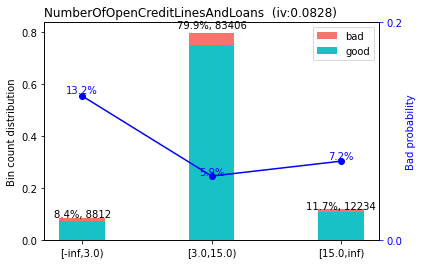

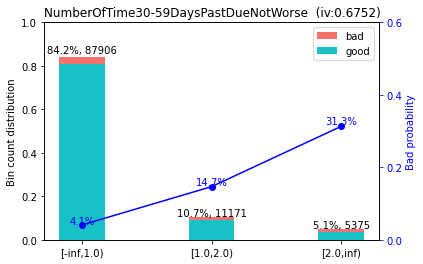

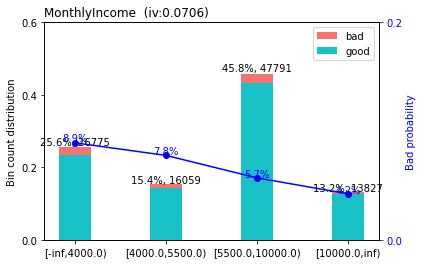

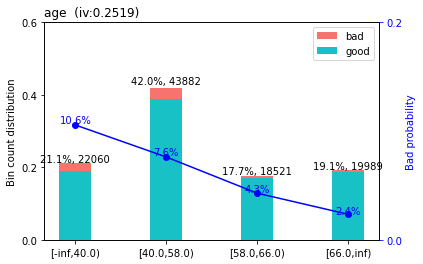

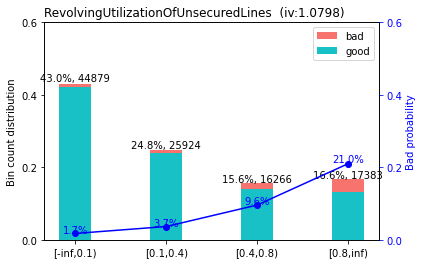

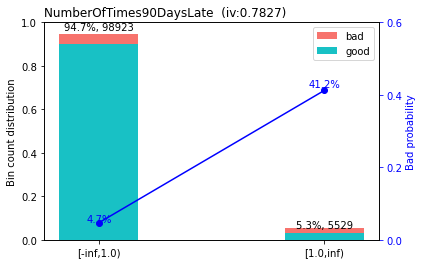

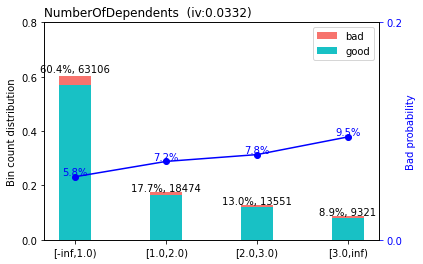

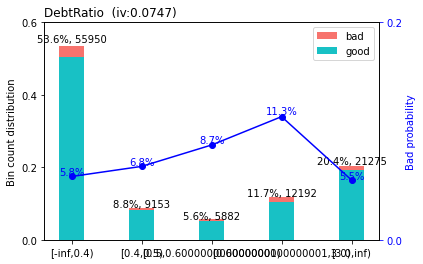

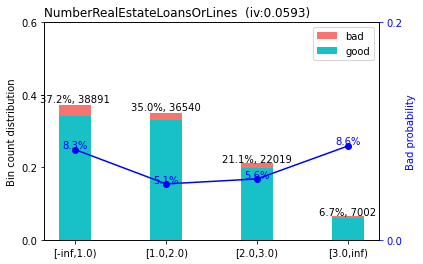

In [482]:
# Разбиваем данные для обучения и теста
new_train, new_test = sc.split_df(data, 'SeriousDlqin2yrs').values()

# Смотрим бины
bins = sc.woebin(data, y="SeriousDlqin2yrs")
sc.woebin_plot(bins)

-------- 1/6 DebtRatio --------
>>> dt[DebtRatio].describe(): 
count    104452.000000
mean        356.053455
std        2172.747226
min           0.000000
25%           0.176965
50%           0.368022
75%           0.873129
max      329664.000000
Name: DebtRatio, dtype: float64 



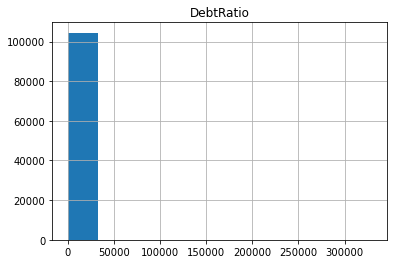

>>> Current breaks:
0.4,0.5,0.6000000000000001,3.0 



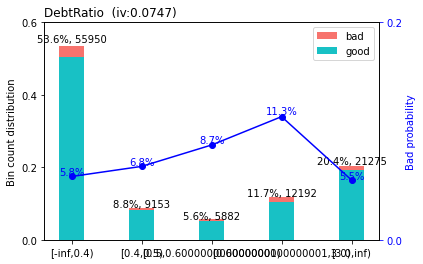

>>> Adjust breaks for (1/6) DebtRatio?
1: next 
2: yes 
3: back
Selection: 1
-------- 2/6 NumberOfDependents --------
>>> dt[NumberOfDependents].describe(): 
count    104452.000000
mean          0.738703
std           1.105139
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          13.000000
Name: NumberOfDependents, dtype: float64 



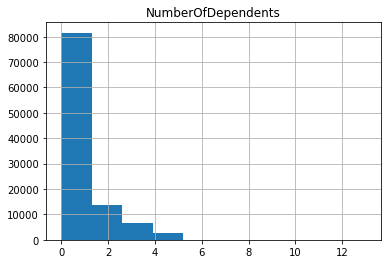

>>> Current breaks:
1.0,2.0,3.0 



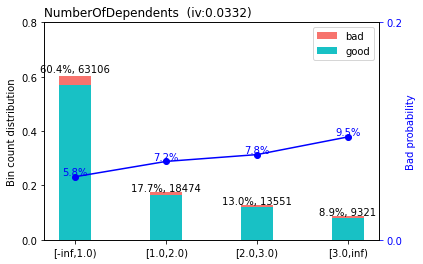

>>> Adjust breaks for (2/6) NumberOfDependents?
1: next 
2: yes 
3: back
Selection: 1
-------- 3/6 NumberOfTime30-59DaysPastDueNotWorse --------
>>> dt[NumberOfTime30-59DaysPastDueNotWorse].describe(): 
count    104452.000000
mean          0.245826
std           0.697108
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          13.000000
Name: NumberOfTime30-59DaysPastDueNotWorse, dtype: float64 



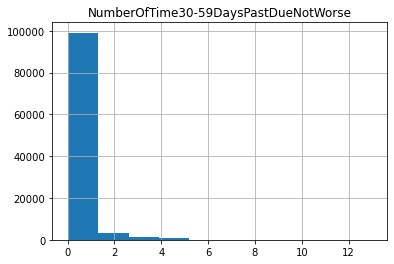

>>> Current breaks:
1.0,2.0 



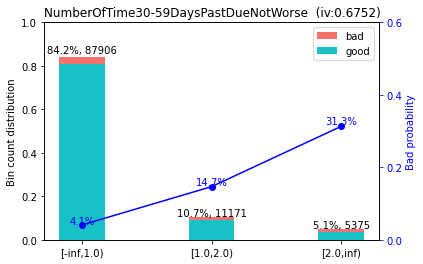

>>> Adjust breaks for (3/6) NumberOfTime30-59DaysPastDueNotWorse?
1: next 
2: yes 
3: back
Selection: 1
-------- 4/6 NumberRealEstateLoansOrLines --------
>>> dt[NumberRealEstateLoansOrLines].describe(): 
count    104452.000000
mean          1.022996
std           1.137218
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max          54.000000
Name: NumberRealEstateLoansOrLines, dtype: float64 



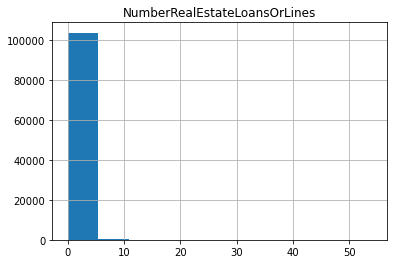

>>> Current breaks:
1.0,2.0,3.0 



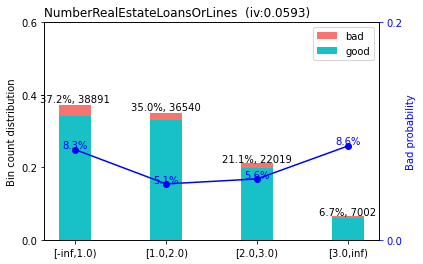

>>> Adjust breaks for (4/6) NumberRealEstateLoansOrLines?
1: next 
2: yes 
3: back
Selection: 1
-------- 5/6 RevolvingUtilizationOfUnsecuredLines --------
>>> dt[RevolvingUtilizationOfUnsecuredLines].describe(): 
count    104452.000000
mean          5.619242
std         217.756704
min           0.000000
25%           0.029997
50%           0.153982
75%           0.557240
max       29110.000000
Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64 



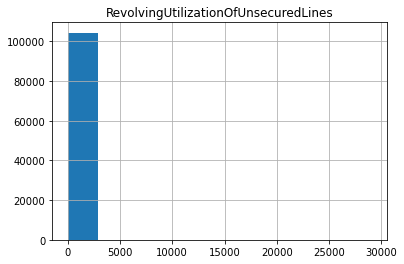

>>> Current breaks:
0.1,0.4,0.8 



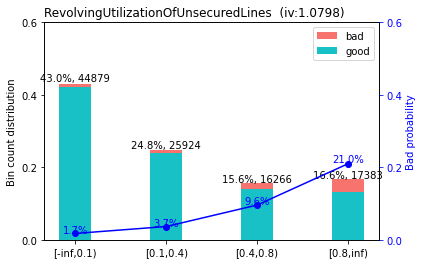

>>> Adjust breaks for (5/6) RevolvingUtilizationOfUnsecuredLines?
1: next 
2: yes 
3: back
Selection: 1
-------- 6/6 age --------
>>> dt[age].describe(): 
count    104452.000000
mean         52.365335
std          14.724192
min          21.000000
25%          41.000000
50%          52.000000
75%          63.000000
max         109.000000
Name: age, dtype: float64 



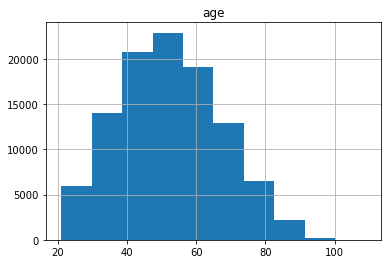

>>> Current breaks:
40.0,58.0,66.0 



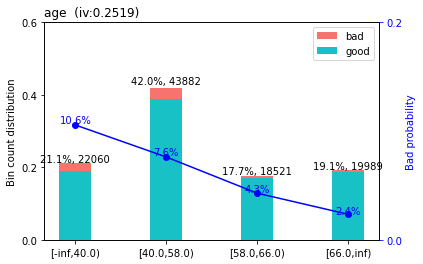

>>> Adjust breaks for (6/6) age?
1: next 
2: yes 
3: back
Selection: 1


In [390]:
# Пробуем некоторые изменения при категоризации для улучшения результата(подбор бинов по умолчанию дал наилучшее качество)
breaks_adj = sc.woebin_adj(data, "SeriousDlqin2yrs", bins)

In [391]:
# Переменные и их бины
breaks_adj

"{'DebtRatio': [0.4,0.5,0.6000000000000001,3.0], 'MonthlyIncome': [4000.0,5500.0,10000.0], 'NumberOfDependents': [1.0,2.0,3.0], 'NumberOfOpenCreditLinesAndLoans': [3.0,15.0], 'NumberOfTime30-59DaysPastDueNotWorse': [1.0,2.0], 'NumberOfTimes90DaysLate': [1.0], 'NumberRealEstateLoansOrLines': [1.0,2.0,3.0], 'RevolvingUtilizationOfUnsecuredLines': [0.1,0.4,0.8], 'age': [40.0,58.0,66.0]}"

In [486]:
# Применяем WoE преобразование для тренировочного и тестового наборов данных
bins_adj = sc.woebin(data, y="SeriousDlqin2yrs", breaks_list=breaks_adj)

train_woe = sc.woebin_ply(new_train, bins_adj)
test_woe = sc.woebin_ply(new_test, bins_adj)

[INFO] creating woe binning ...
[INFO] converting into woe values ...
[INFO] converting into woe values ...


In [487]:
# Соединяем в единый фрейм для конечного обучения
data_woe = pd.concat([train_woe, test_woe])

In [488]:
# Разбиваем в ручную
y_train = train_woe.loc[:,'SeriousDlqin2yrs']
X_train = train_woe.loc[:,train_woe.columns != 'SeriousDlqin2yrs']
y_test = test_woe.loc[:,'SeriousDlqin2yrs']
X_test = test_woe.loc[:,train_woe.columns != 'SeriousDlqin2yrs']

In [489]:
# Небольшой подбор гиперпараметров
params_woe = {
              'penalty': ['l2', 'none'],
              'C': [1, 10, 30]}

In [490]:
%%time
gs_lr = GridSearchCV(LogisticRegression(random_state=32, n_jobs=-1),
                     param_grid=params_woe, scoring='roc_auc', cv=5).fit(X_train, y_train)


Wall time: 1min 5s


In [491]:
gs_lr.best_params_

{'C': 10, 'penalty': 'l2'}

In [492]:
gs_lr.best_score_

0.8480637948145553

In [493]:
# Качество на отложенной выборке
y_pred = gs_lr.predict_proba(X_test)[:, 1]

roc_auc_score(y_test, y_pred)

0.8503582225625016

In [494]:
# Обучаем конечную модель на полном наборе WoE трансформированных признаков
model = LogisticRegression(C=10, random_state=32, n_jobs=-1).fit(data_woe.iloc[:, 1:], data_woe['SeriousDlqin2yrs'])

In [495]:
# Преобразования тестовго набора
id_test = test.pop('Id')

test.isna().sum()

RevolvingUtilizationOfUnsecuredLines       0
age                                        0
NumberOfTime30-59DaysPastDueNotWorse       0
DebtRatio                                  0
MonthlyIncome                           8950
NumberOfOpenCreditLinesAndLoans            0
NumberOfTimes90DaysLate                    0
NumberRealEstateLoansOrLines               0
NumberOfTime60-89DaysPastDueNotWorse       0
NumberOfDependents                      1175
dtype: int64

In [496]:
test.MonthlyIncome.fillna(test.MonthlyIncome.mean(), inplace=True)
test.NumberOfDependents.fillna(test.NumberOfDependents.median(), inplace=True)

test.isna().sum()

RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
dtype: int64

In [497]:
# Применяем WoE трансформацию на тестовом наборе
res = sc.woebin_ply(test, bins_adj)

[INFO] converting into woe values ...


In [498]:
# Удаляем признак из тестового набора, который был автоматически удален при рассчете WoE ренировочного набора
res = res.drop('NumberOfTime60-89DaysPastDueNotWorse', axis=1)

In [499]:
# Предсказанные вероятности тестового набора данных
predicted = model.predict_proba(res)

In [500]:
submission = pd.DataFrame(id_test,)
submission['SeriousDlqin2yrs'] = predicted[:, 1]
submission

,Id,SeriousDlqin2yrs
0,0,0.334091
1,9,0.053524
2,17,0.027812
3,18,0.032072
4,24,0.009909
...,...,...
45190,149992,0.069325
45191,149994,0.033105
45192,149995,0.007473
45193,149996,0.039103


In [501]:
submission.to_csv('Give me some credit_woe_full.csv', index=False)